In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.0.0


In [2]:
# Keras provides a handy API to download the MNIST dataset, and split them into
# "train" dataset and "test" dataset.
mnist = keras.datasets.mnist
(org_train_images, org_train_labels), (org_test_images, org_test_labels) = mnist.load_data()

# 60,000 training data and 10,000 test data of 28x28 pixel images
print("train_images shape", org_train_images.shape)
print("train_labels shape", org_train_labels.shape)
print("test_images shape", org_test_images.shape)
print("test_labels shape", org_test_labels.shape)


train_images shape (60000, 28, 28)
train_labels shape (60000,)
test_images shape (10000, 28, 28)
test_labels shape (10000,)


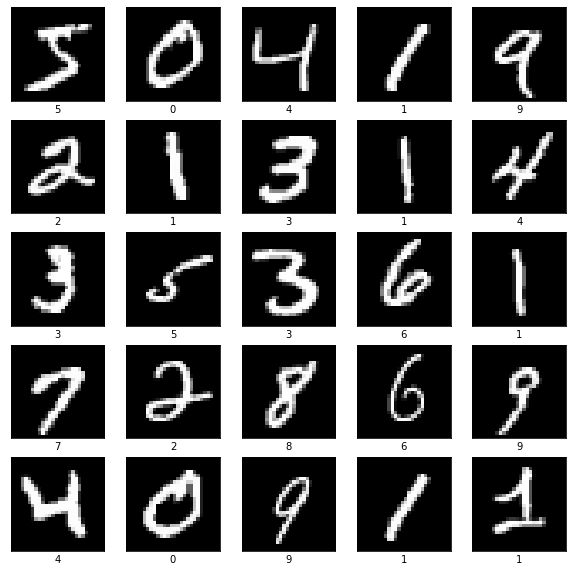

In [3]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(org_train_images[i], cmap=plt.cm.gray)
  plt.xlabel(org_train_labels[i])
plt.show()

In [4]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = org_train_images;
test_images = org_test_images;
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = org_train_labels.astype("float32")
test_labels = org_test_labels.astype("float32")

print('Pixels are normalized')

Pixels are normalized


In [5]:
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  #keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(32, activation=tf.nn.relu),
  keras.layers.Dense(10),
  keras.layers.Activation(tf.nn.softmax)
])



# Define how to train the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the digit classification model
model.fit(train_images, train_labels, batch_size=128, epochs=5, verbose=1)


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 119us/sample - loss: 0.3767 - accuracy: 0.8937
Epoch 2/5
60000/60000 [==============================] - 7s 119us/sample - loss: 0.1396 - accuracy: 0.9597
Epoch 3/5
60000/60000 [==============================] - 7s 113us/sample - loss: 0.1047 - accuracy: 0.9694 - los
Epoch 4/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.0841 - accuracy: 0.9752
Epoch 5/5
60000/60000 [==============================] - 9s 146us/sample - loss: 0.0701 - accuracy: 0.9792


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 864)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                27680     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
activation (Activation)      (None, 10)                0

In [7]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test accuracy: 0.9779


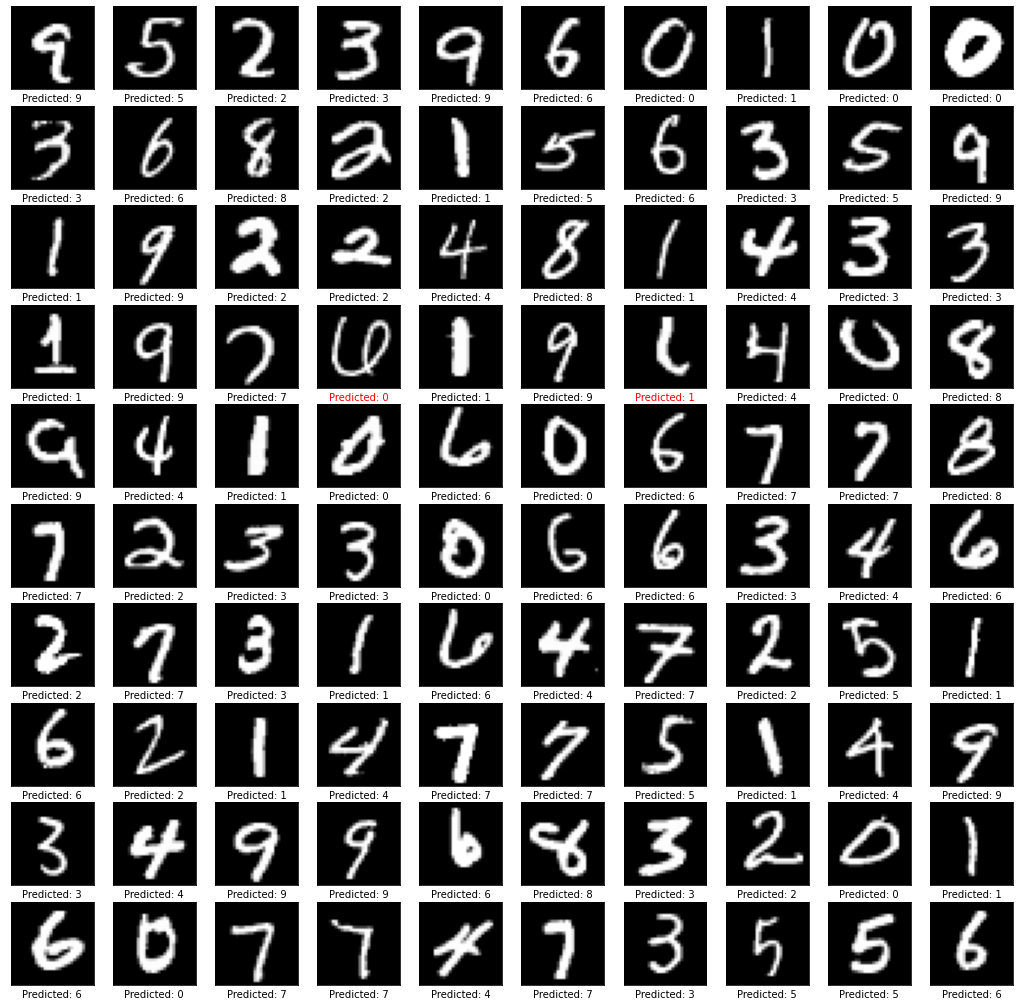

In [8]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(org_test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           org_test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

In [15]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)
# Save the model to disk
open('model.tflite', "wb").write(tflite_float_model)

Float model size = 112KBs.


114804

In [16]:
interpreter = tf.lite.Interpreter('model.tflite')
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: input_1
shape: [ 1 28 28]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [ 1 10]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'input_1', 'index': 1, 'shape': array([ 1, 28, 28]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}

DUMP OUTPUT
{'name': 'Identity', 'index': 0, 'shape': array([ 1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}


In [17]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
header_file = "const unsigned char model_tflite[] = {\n  " + ascii_bytes + "\n};\nunsigned int model_tflite_len = " + str(len(tflite_binary)) + ";"
# print(c_file)
open("spresense_tf_mnist/model.h", "w").write(header_file)

711866